# Projet Final - GBM8770
## Multi-Scale Line Detector

Équipe #22
- Beaudry, Sophie (Matricule)
- Nom, Prénom (Matricule)

In [1]:
# Vous permet de modifier vos fichiers importés et que les changements soient appliqués
# automatiquement, sans avoir à redémarer le notebook.
%load_ext autoreload  
%autoreload 2         

from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import skimage.morphology as skmorph

%matplotlib inline
plt.rcParams["figure.figsize"] = (18, 8)  # Étend la taille des figures

In [2]:
from src.algo import MultiScaleLineDetector, dice, learn_threshold, naive_metrics
from src.dataset import Sample, load_dataset
from src.viz import plot_roc, show_diff


# 1. Implémentation de la MSLD

## 1.1. Préparatifs

Pour entraîner et valider l’algorithme, nous allons utiliser la base de données DRIVE fournie dans l'archive.


**Q1.** Complétez la fonction `load_dataset()` pour qu’elle charge et renvoie la base de données d’entraînement et de test (en incluant pour chaque échantillon: l’image, le label et le masque). Puis affichez l’image, le label et le masque de la première image de l’ensemble d’entraînement.

*(On notera cette image I1.)*

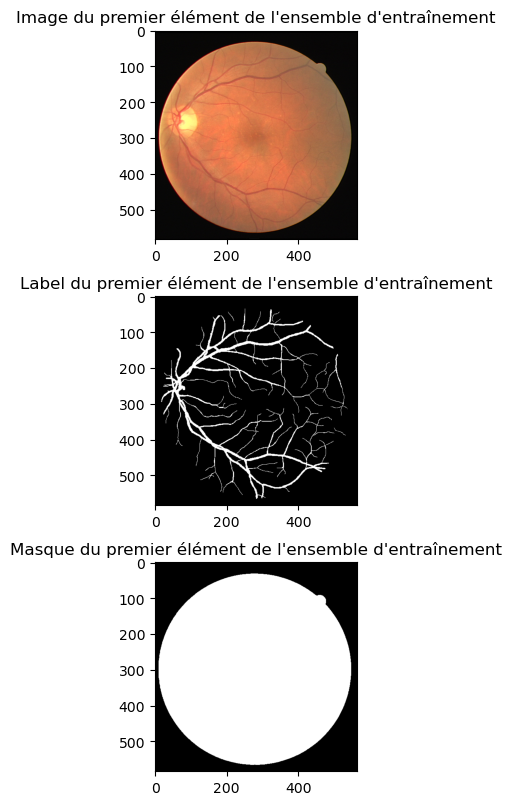

In [3]:
train, test = load_dataset()
I1 = train[0]

fig, axes = plt.subplots(3, 1)
fig.tight_layout(h_pad=2.0)

axes[0].set_title("Image du premier élément de l'ensemble d'entraînement")
axes[0].imshow(I1.image)
axes[1].set_title("Label du premier élément de l'ensemble d'entraînement")
axes[1].imshow(I1.label, cmap="gray")
axes[2].set_title("Masque du premier élément de l'ensemble d'entraînement")
axes[2].imshow(I1.mask, cmap="gray");

## 1.2. Basic Line Detector

Dans un soucis d’optimisation de l’implémentation, nous allons utiliser des convolutions dès que cela est possible. Particulièrement pour le calcul des moyennes d’intensités sur une fenêtre de taille `W` et le long des lignes de longueur `L`. De plus ces masques ne seront calculés qu’une seule fois, lors de l’instanciation de la classe MSLD.

**Q1.** Quel filtre de convolution permet le calcul de la valeur moyenne d’une fenêtre de taille `W` autour d'un pixel ? Complétez le constructeur de la classe `MultiScaleLineDetector` en définissant `avg_mask`.


Le filtre moyenneur permet le calcul de la valeur moyenne d'un pixel par une convolution. Celui-ci est simplement créé en prenant une matrice de 1 de taille WxW, puis en la divisant par la somme de ces composantes.

**Q2.** On souhaite implémenter le BLD en utilisant des masques de convolution. Ces masques viendront sélectionner les pixels le long d'une ligne. Ils seront définis par leur longuer `L` et une série d'orientations. Expliquez comment construire les masques pour permettre le calcul de la valeur moyenne le long de lignes de taille `L` pour `num_orientations`. Complétez le constructeur de la classe `MultiScaleLineDetector` avec la définition de `line_detectors_masks`.

Pour construire les masques permettant le calcul de la valeur moyenne le long des lignes, nous commençons par créer le masque de la ligne horizontale. Ce masque est créé  en superposant des vecteurs de zéro ou de un de dimension (1, `l`). Cette technique suppose que les valeurs dans `L` sont tous impairs. Nous tournons ensuite ce masque à l'aide d'une matrice de rotation standard en 2D. La variable `num_orientations` est utilisée afin de déterminer les angles à utiliser lors de la rotation. 

In [6]:
# Vous pouvez dès à présent instancier l'objet MSLD en remplaçant les hyper-paramètres W, L et num_orientations par
# leurs valeurs conseillées par l'article.
msld = MultiScaleLineDetector(W=15, L=list(range(1,17,2)), num_orientations=12)

**Q3.** À l’aide de la section 3.1 de l’article, implémentez `basic_line_detector(grey_lvl, L)`.

**Q4.** Affichez la réponse du filtre appliqué à l’image I1 pour les longueurs L=1 et L=15. Comparez les deux et commentez.   

*Note: Attention le filtre BLD ne s’applique pas à tous les canaux de l’image. Relisez la section 3.1 de l’article pour plus d’informations...*

In [ ]:
grey_lvl_I1 = ...
I1_bld_L1 = msld.basic_line_detector(grey_lvl_I1, L=1)
I1_bld_L15 = msld.basic_line_detector(grey_lvl_I1, L=15)

## 1.3. Multi-Scale Line Detector

**Q1.** À l’aide des sections 3.2 et 3.3 de l’article et de la méthode `self.basic_line_detector(grey_lvl, L)` déjà implémentée, implémentez `multi_scale_line_detector(image)`.

**Q2.** Affichez le résultat de l’algorithme appliqué à l’image I1. Comparez avec les réponses du filtre obtenues à la question 1.2.4, et commentez.

In [ ]:
I1_msld = msld.multi_scale_line_detector(I1.image)

## 1.4. Apprentissage du seuil
 
Pour calculer le seuil donnant la meilleure précision sur l’ensemble d’entraînement efficacement, nous allons utiliser la courbe [ROC (Receiver Operating Characteristic)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). Cette courbe sera étudiée en détail dans la partie 2. Pour le moment, il vous faut juste savoir qu’elle associe à chaque seuil possible, le taux de faux positifs et le taux de vrais positifs si ce seuil était choisi.

**Q1.** Donnez la formule de la précision ACC (*accuracy* en anglais) en fonction du taux de faux positifs FPR, du taux de vrais positifs TPR, ainsi que du nombre de valeurs positives P, de valeurs négatives N et du nombre total de pixels S de la région d'intéret.   

Utilisez la syntaxe $\LaTeX$ pour formatter l'équation.

*(Vous pouvez vous aider des formules indiqués sur la page Wikipédia de la courbe ROC.)*

Pour vous faire gagner du temps, on vous donne la fonction `roc(msld, dataset)` qui calcule le TPR et le FPR associé à chaque seuil possible pour un dataset donné. Cette fonction utilise la fonction [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) de `sklearn`. Assurez-vous que vous comprenez bien chaque ligne du code.

**Q2.** Pourquoi est-il si important de ne sélectionner uniquement les pixels qui appartiennent au masque? En particulier, comment évoluerait la précision si on sélectionnait finalement tous les pixels de l'image (sachant que hors du masque la prédiction du MSLD est toujours nulle)?

**Q3.** À l’aide de la fonction `roc(msld, dataset)` et de la formule de la question 1 de cet exercice, complétez la fonction
`learn_threshold(msld, dataset)` qui identifie le seuil pour laquelle la précision est la plus élevée.


**Q4.** Utilisez cette fonction pour apprendre le seuil sur les images d’entraînement. Pour quelle raison faut il absolument conserver une partie des images (l’ensemble de test) et ne pas les utiliser pendant l’entraînement?

*N.B.: il n’est pas anormal d’obtenir un seuil différent de celui annoncé par les auteurs...*


In [ ]:
threshold, accuracy = learn_threshold(msld, train)

## 1.5. Affichage et région d’intérêt

**Q1.** Implémentez la méthode `segment_vessels(image, threshold)` qui applique le seuil à la carte de probabilité calculée sur une image. Affichez le résultat de l’algorithme sur l’image I1.


**Q2.**  Vous devriez voir apparaître des erreurs de segmentations aux bords du fond d’oeil (à la frontière circulaire entre le fond d'oeil et le fond noir). À quoi est dû ce phénomène?



**Q3.** Pour palier à ce problème, dupliquez les datasets, érodez la région d'intérêt (le masque) de manière à réduire le diamètre de 10 pixels, puis effectuez l'apprentissage du seuil à nouveau. Comparez les valeurs de seuil et la précision globale.



In [ ]:
# Duplique les dataset
train_eroded = deepcopy(train)
test_eroded = deepcopy(test)

for d in train_eroded:
    # Erosion
    d.mask = ...

# Même opération pour test_eroded

**Q4.** On vous donne la fonction `show_diff(msld, sample, threshold, ax)` qui affiche les faux positifs en rouge, les faux négatifs en bleu, les vrais positifs en blanc et les vrais négatifs en noirs. Avec cette fonction, affichez la différence entre la prédiction et le label sur l’image I1. Commentez le résultat.

# 2. Métriques de segmentation

## 2.1. Précision globale et locale

**Q1.** Implémentez la fonction `naive_metrics(msld, dataset, threshold)` qui évalue la précision et la matrice de confusion de l’algorithme pour un dataset donné. Puis calculez ces métriques sur l’ensemble de test.
*(N’oubliez pas de ne sélectionner que les pixels appartenant à la région d’intérêt!)*


**Q2.** Utilisez la fonction `show_diff` pour afficher la prédiction sur `I1` à différents seuils et calculez la précision associée à chacun de ces seuils. Indiquez la valeur du seuil et la précision dans le titre de chaque carte de différence. Commentez sur l'effet du seuil.

In [ ]:
seuils = [0.3, 0.5, threshold, 0.6, 0.8]  # Utilisez les valeurs de seuil fournies

**Q3.** Les auteurs proposent une seconde métrique: la précision locale. Quelles raisons avancent-ils
pour motiver cette proposition?


**Q4.** Grâce à une opération morphologique, créez une copie du dataset ``test`` tel que son attribut mask corresponde à la région d’intérêt "locale" proposée par les auteurs. Puis, sans modifier la fonction `naive_metrics(msld, dataset, threshold)`, calculez la précision et la matrice de confusion locale.


In [ ]:
test_local = deepcopy(test)

...

**Q5.** Cette seconde métrique met plus en valeur l’algorithme proposé que la précision globale. Au vu des erreurs de l’algorithme révélées à la question 4 de l'exercice I.5, donnez une raison supplémentaire (omise par les auteurs) qui explique ce phénomène. 

## 2.2. Indice Dice (bonus)
De nombreux indices existent pour mieux évaluer les performances de segmentation que la précision globale: précision balancée, indice de Jaccard, kappa de Cohen, etc. Nous allons ici utiliser l'indice Sørensen-Dice. En notant $Y$ les labels et $\hat{Y}$ les prédictions de l'algorithme, l'indice Dice est défini par
$$\text{Dice}(Y, \hat{Y}) = 2\dfrac{Y \cap \hat{Y}}{Y + \hat{Y}}.$$

**Q1.** En quoi cette métrique répond aux limitations de la précision globale?

**Q2.** Implémentez la fonction `dice(msld, dataset, threshold)` et calculez sa valeur sur la région d’intérêt globale et locale sur l’ensemble de test.


## 2.3. Courbe ROC et aire sous la courbe


Le choix d’un seuil de segmentation revient à faire un compromis entre faux-positifs et faux-négatifs (un seuil élevé limitera les faux-positifs mais augmentera les faux-négatifs et inversement). Le choix du bon compromis dépend bien souvent de l’application. Cependant les algorithmes se distinguent par le choix des caractéristiques à seuiller (ici un filtre MSLD) plutôt que par la méthode de sélection du seuil... [La courbe ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic##Area_under_the_curve) permet de représenter les performances de l’algorithme indépendamment du seuil choisi.   

Pour construire cette courbe, on calcule le taux de faux-positifs (FPR) et le taux de vrais-positifs (TPR=1−FNR) pour chaque valeur de seuil. La courbe obtenue (FPR en abscisse, TPR en ordonnée) caractérise l’efficacité de l’algorithme à distinguer les vaisseaux du fond, indépendamment du seuil.

Enfin, pour simplifier la comparaison entre deux courbes ROC, on extrait leurs [aires sous la courbe (AUC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic##Area_under_the_curve).

**Q1.** Que signifie une AUC de 1, de 0,5 ou de 0 pour les performances du modèle?


**Q2.**  Implémentez la fonction `plot_roc(msld, dataset, ax)` qui trace la courbe ROC et calcule son AUC. Puis faites de même pour la région d’intérêt globale et pour la région d’intérêt locale. Comparez les résultats et commentez.

# 3. Validation de l’hypothèse de recherche de l’article

À l’aide de votre implémentation de l’algorithme et des différents cas du dataset de test, discutez de la qualité du protocole expérimental pour vérifier les hypothèses de recherche sous-jacentes de l’article (telles que vous les aviez formulé dans le devoir 2).

# 4. Discussion



**Q1.** Discutez du choix des hyper-paramètres `W`, `L` (nombre d’échelles et répartition) et `num_orientations`. Leurs valeurs ont-elles des justifications théoriques? Quels sont leur impact en pratique?

**Q2.** Les auteurs ont choisi le seuil donnant la meilleure précision sur l’ensemble d’entraînement. Connaissant les analyses effectuées dans la partie 2, discutez de ce choix.

**Q3.** En vous appuyant sur vos expérimentations pour les deux dernières parties de cet énoncé, proposez des recommandations pour améliorer l’algorithme.